**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 9.12.**
* **Bonus problems: deadline for Lab Assignment 4**

However, because the list is published late, you get extra 7 late days *for the problems in this list only*.

**Points: 11 + 5 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [0]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt
from scipy.linalg import solve_triangular

import seaborn as sns
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
import sklearn.ensemble
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

import graphviz


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

# Problem 1 [2p] Linear Regression

1. Implement a function generating a dataset of $n$ points
  according to the following algorithm:
  1. Draw $n$ points $x \propto U(0;10)$ (uniformly distributed on $[0,10]$).
  2. Draw $n$ points $y \propto \mathcal{N}(1+20x-1.3x^2, 7)$
    (from a Gaussian distribution with $\mu=1+20x-1.3x^2$ and $\sigma=7$).

  Prepare a dataset of 30 elements and make a scatterplot of
  the expected value $y$ in function $x$.

2. Use linear regression to fit polynomials to the
  generated dataset. Fit polynomials of degrees zero (a constant line),
  one, two and three. An easy way to do it is to transform each data
  point $x$ into a vector of its powers $[1, x, x^2, \ldots, x^m]$.

  Plot the dataset and all regression curves on one figure.

  **Note:** The name _linear regression_ signifies that the
  hypothesis is linear with respect to parameters $\Theta$.
  However, the relationship between $x$ and $y$ is not constrained
  to a linear one. In this exercise it is a polynomial one.

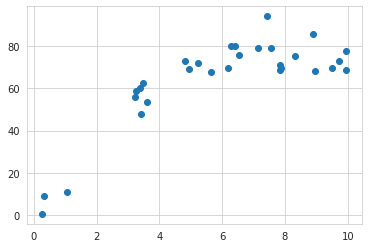

In [0]:
def make_dataset(N):
    X = np.random.uniform(0,10,N)
    Y = 7 * np.random.randn(N) + (1 + 20*X - 1.3 * (X**2))
    return X, Y

data = make_dataset(30)
plt.scatter(data[0], data[1])

[[64.13995236]] (1, 1)
[[28.10266436]
 [ 6.03794609]] (2, 1)
[[-2.11513613]
 [21.60518655]
 [-1.44819722]] (3, 1)
[[-4.90830246]
 [25.18357299]
 [-2.31682606]
 [ 0.05586506]] (4, 1)


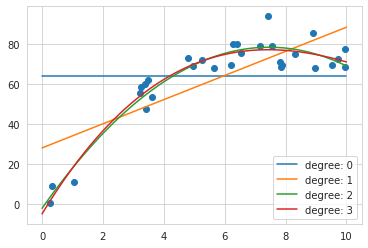

In [0]:
from numpy.linalg import inv

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(-1,1)
    return X**powers

def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1) # len(Theta) x N
    Y = np.sum(XP * Theta,axis=0)
    return Y

plot_x_space = np.linspace(0,10,100)
plt.scatter(data[0], data[1])
for degree in range(4):
    X = powers_of_X(data[0], degree) # Matrix d x N
    Y = data[1].reshape(1, -1)       # Matrix 1 x N
    # Theta = (X * X^T)^-1 * X * y
    Theta = np.dot(np.dot(inv(np.dot(X,X.T)),X),Y.T)
    print(Theta, Theta.shape)
    plt.plot(plot_x_space, compute_polynomial(plot_x_space, Theta).ravel(), 
         label="degree: %d" %(degree, ))
plt.legend(loc='lower right')

# Problem 2 [2p] Ridge Regression

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{2}\sum_{i=1}^N (y^{(i)} - \Theta^T x^{(i)})^2 + \frac{\lambda}{2} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$

Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\lambda$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\lambda$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for lambda on the test set, explain the model behavoir for small lambdas and large lambdas.

Then use a small lambda for numerical stability (1e-6) and train the model on increasingly large training sets. Plot th etraining cureves (train and test error rates versus amount of training data)

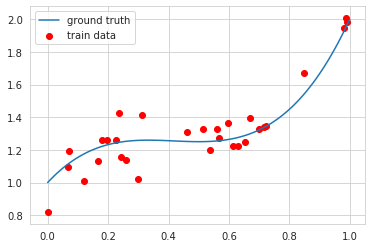

In [0]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#
true_poly_theta = np.array([1, 2, -5, 4]).reshape(-1,1)

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.rand(N)
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N) * sigma
    return X,Y

train_data = make_dataset(30)
XX = np.linspace(0,1,100)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label='train data', color='r')
plt.plot(XX, compute_polynomial(XX, true_poly_theta).ravel(), label='ground truth')
plt.legend(loc='upper left')

In [0]:
def qr_inv(a):
    q,r = np.linalg.qr(a, mode='complete')
    inv_ = np.dot(inv(r),q.T)
    return inv_

In [0]:
def qr_inv2(a):
    q,r = np.linalg.qr(a, mode='complete')
    N = r.shape[0]
    inv_ = np.dot(solve_triangular(r,np.eye(N)),q.T)
    return inv_

In [0]:
#please note: lambda is a reserved keyword in python, thus we use _lambda
def poly_fit(data, degree, _lambda):
    "Fit a polynomial of a given degree and weight decay parameter _lambda"
    X = powers_of_X(data[0], degree) # Matrix d x N
    Y = data[1].reshape(1, -1)       # Matrix 1 x N
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    #
    I = np.eye(degree+1)
    # Theta = (X * X^T + lambda * I )^-1 * X * y
    Theta = np.dot(np.dot(qr_inv2(np.dot(X,X.T) + _lambda * I),X),Y.T)
    return Theta

In [0]:
def err_of_fit(data,Theta):
    X,Y = data
    XP = powers_of_X(X, len(Theta) - 1)
    fited_Y = np.sum(XP * Theta,axis=0)
    return np.mean((fited_Y-Y)**2)

In [0]:
num_test_samples = 100
num_train_samples = [30]
lambdas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


#sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition,
     num_train,
     _lambda,
     degree,) in itertools.product(
         range(num_repetitions),
         num_train_samples,
         lambdas,
         degrees):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, _lambda)
    train_err = err_of_fit(train_data,Theta)
    test_err = err_of_fit(test_data,Theta)
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'train',
                    'err_rate': train_err})
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'test',
                    'err_rate': test_err})
results_df = pd.DataFrame(results)
results_df.head()

,repetition,num_train,lambda,degree,dataset,err_rate
0,0,30,0.0,0,train,0.036200
1,0,30,0.0,0,test,0.049741
2,0,30,0.0,1,train,0.025575
3,0,30,0.0,1,test,0.022533
4,0,30,0.0,2,train,0.016583


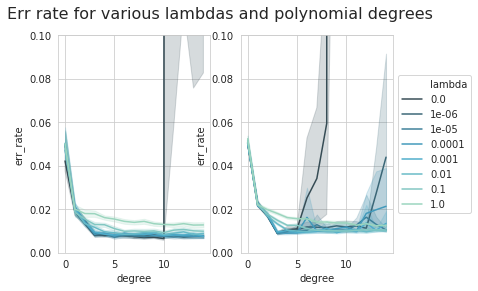

In [0]:
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for lambda on the test set, explain the model
# behavoir for small lambdas and large lambdas.
#
fig, axe = plt.subplots(1,2)
fig.suptitle("Err rate for various lambdas and polynomial degrees", fontsize=16)
sns.lineplot(x='degree',y='err_rate',hue='lambda',data=results_df.loc[results_df['dataset'] == 'train'],legend=False,palette=sns.color_palette("GnBu_d",8),ax=axe[0])
axe[0].set_ylim(0,0.1)
p2 = sns.lineplot(x='degree',y='err_rate',hue='lambda',data=results_df.loc[results_df['dataset'] == 'test'],legend='full',palette=sns.color_palette("GnBu_d",8),ax=axe[1])
axe[1].set_ylim(0,0.1)
p2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

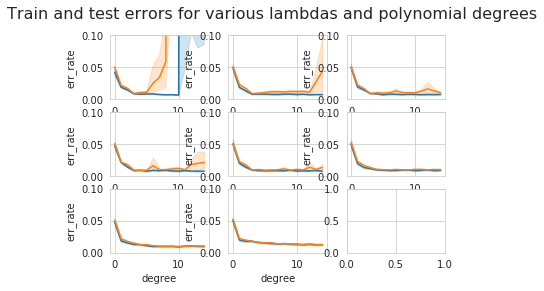

In [0]:
fig, axe = plt.subplots(3,3)
fig.suptitle("Train and test errors for various lambdas and polynomial degrees", fontsize=16)
for i in range(3):
    for j in range(3):
        if i==j==2:
            break
        n = 3*i+j
        l = lambdas[n]
        axe[i,j].set_ylim(0,0.1)
        sns.lineplot(x='degree',y='err_rate',hue='dataset',data=results_df.loc[results_df['lambda'] == l],ax=axe[i,j],legend=False)


In [0]:
num_test_samples = 100
num_train_samples = np.linspace(10,1000,50,dtype=int)
lambdas = [0.000001]
degrees = range(15)
num_repetitions = 30


#sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition,
     num_train,
     _lambda,
     degree,) in itertools.product(
         range(num_repetitions),
         num_train_samples,
         lambdas,
         degrees):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, _lambda)
    train_err = err_of_fit(train_data,Theta)
    test_err = err_of_fit(test_data,Theta)
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'train',
                    'err_rate': train_err})
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'test',
                    'err_rate': test_err})
results2_df = pd.DataFrame(results)
results2_df.head()

,repetition,num_train,lambda,degree,dataset,err_rate
0,0,10,0.000001,0,train,0.057261
1,0,10,0.000001,0,test,0.052905
2,0,10,0.000001,1,train,0.026156
3,0,10,0.000001,1,test,0.036287
4,0,10,0.000001,2,train,0.021804


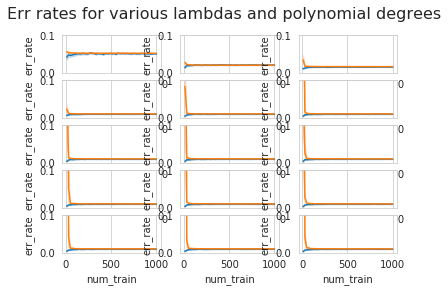

In [0]:
# TODO
# Now set a small regularizatoin for numerical stability  (e.g. lambda=1e-6) 
# and present the relationship between
# train and test error rates for varous degrees of the polynomial for 
# different sizes of the train set.
#
fig, axe = plt.subplots(5,3)
fig.suptitle("Err rates for various lambdas and polynomial degrees", fontsize=16)
for i in range(5):
    for j in range(3):
        deg = i*3+j
        axe[i,j].set_ylim(0,0.1)
        sns.lineplot(x='num_train',y='err_rate',hue='dataset',data=results2_df.loc[results2_df['degree'] == deg],ax=axe[i,j],legend=False)


# Problem 3 [1p + 2bp] Numerical optimization

Implement the [Rosenborck function](https://en.wikipedia.org/wiki/Rosenbrock_function). Then find its optimum using the [`scipy.optimize.fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html).

In [0]:
def numerical_gradient(f, X, delta=1e-20):
    X = np.array(X) # force a copy
    R = np.zeros_like(X)
    XF = X.ravel() #get the views
    RF = R.ravel() 
    for i in range(XF.shape[0]):
        xold = XF[i]
        XF[i] = xold+delta
        fp, unused_grad = f(X)
        XF[i] = xold-delta
        fn, unused_grad = f(X)
        XF[i] = xold
        RF[i] = (fp-fn)/(2*delta)
    return R

def check_gradient(f, X, delta=1e-4, prec=1e-6):
    fval, fgrad = f(X)
    num_grad = numerical_gradient(f, X, delta=delta)
    diffnorm = np.sqrt(np.sum((fgrad-num_grad)**2))
    gradnorm = np.sqrt(np.sum(fgrad**2))
    if gradnorm>0:
        if not (diffnorm < prec or diffnorm/gradnorm < prec):
            raise Exception("Numerical and anaylical gradients differ: %s != %s!" %
                            (num_grad, fgrad))
    else:
        if not (diffnorm < prec):
            raise Exception("Numerical and anaylical gradients differ: %s != %s!" %
                            (num_grad, fgrad))
    return True

In [0]:
#
# Implement the Rosenbrock function
#
'''
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    from common.gradients import check_gradient
'''
def rosenbrock_v(x):
    return 100 * (x[1] - (x[0])**2)**2 + (1-x[0])**2

def rosenbrock(x):
    """Returns the value of rosenbrock's function and its gradient at x
    """
    val = rosenbrock_v(x)
    dVdX1 = 400*(x[0])**3 - 400*x[0]*x[1] + 2*x[0] -2
    dVdX2 = 200*(x[1]-(x[0])**2)
    dVdX = np.array([dVdX1,dVdX2])
    return [val, dVdX]

#
# Feel free to add your own test points.
#
for test_point in [[0., 0.],
                   [1., 1.],
                   [0.5, 1.0],
                   [1.0, 0.5]]:
    assert check_gradient(rosenbrock, np.array(test_point), prec=1e-5)

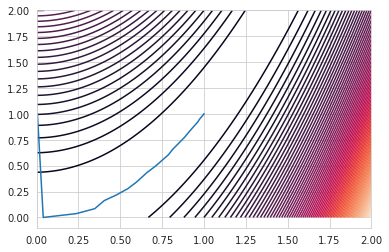

In [0]:
#
# Use scipy.optimize.fmin_l_bfgs_b
# Make a contour plot of the RosenB=brock function, plot the optimizatoin path
# on the coutnour plot
#
# Hint: to save the points you can use the callback argument!
#

import scipy.optimize as sopt
lbfsg_hist = []

def save_hist(x):
    lbfsg_hist.append(list(x))

x_start = [0.,2.]
lbfsgb_ret = sopt.fmin_l_bfgs_b(rosenbrock, x_start, callback=save_hist)

#plot the countours of the function and overlay the optimization trajectory
lbfsg_hist = np.array(lbfsg_hist)
N = 500
X, Y = np.meshgrid(np.linspace(0,2,N), np.linspace(0,2,N))
Z = np.dstack((X,Y))
Z = Z.reshape(N*N,2)
Z = np.apply_along_axis(rosenbrock_v, 1, Z)
Z = Z.reshape(N,N)
plt.contour(X, Y, Z,levels=100)
plt.plot(lbfsg_hist[:,:1],lbfsg_hist[:,1:2])

In [0]:
def rosenbrock_hessian(x):
    # compute the value, gradient and Hessian of Rosenbrock's function'
    val = rosenbrock_v(x)
    dVdx0 = 400*(x[0])**3 - 400*x[0]*x[1] + 2*x[0] -2
    dVdx1 = 200*(x[1]-(x[0])**2)
    dVdx02 = 2-400*x[1]+1200*(x[0])**2
    dVdx12 = 200
    dVdx0x1 = -400*x[0]
    H = np.array([[dVdx02,dVdx0x1],[dVdx0x1, dVdx12]])
    return [val, np.array((dVdx0, dVdx1)), H]

In [0]:
def wolfe_conditions(f, xk, step_size, c1 = 0.1, c2 = 0.9):
    f_xk,grad,H = f(xk)
    pk = -np.dot(qr_inv2(H),grad)
    f_xk_sspk,grad_xk_sspk,_ = f(xk + step_size*pk)
    if f_xk_sspk <= f_xk + c1*step_size*np.dot(pk.T,grad):
        if -np.dot(pk.T,grad_xk_sspk) <= -c2*np.dot(pk.T,grad):
            return True
    return False

Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Tried step length: 0.5
Tried step length: 0.25
Tried step length: 0.125
Accepted step length: 0.125
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Tried step length: 0.5
Accepted step length: 0.5
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Tried step length: 0.5
Accepted step length: 0.5
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Tried step length: 1.0
Accepted step length: 1.0
Found optimum at [1. 1.] in 17 steps (21 function evals)(true minimum is at [1,1])


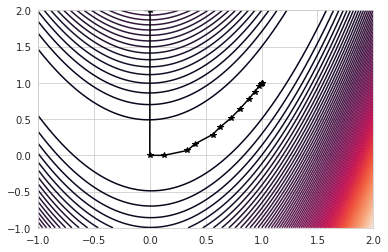

In [0]:
#
# Bonus problem
#

# Newtod-Raphson Method

def Newton(f, x0, alpha, stop_tolerance=1e-10, max_steps=1000000):

    #  - implement the newton method and a simple line search
    #  - make sure your function is resilient at critical points (such as seddle points)
    #  - if the Newton direction is not minimizing the function, use the gradient for a few steps
    #  - try to beat L-BFGS on the bmber of function evaluations needed!

    step = 0
    history, fun_evals = [list(x0)],0

    xn = x0
    f_xn,grad,H = f(xn)
    # and (grad[0] > stop_tolerance or grad[1] > stop_tolerance)
    while step < max_steps and (abs(0-grad[0]) > stop_tolerance or abs(0-grad[1]) > stop_tolerance):
        step += 1
        changed = False
        for try_step in range(10):
            step_size = alpha/(2**try_step)
            print(f"Tried step length: {step_size}")
            fun_evals += 1
            if wolfe_conditions(f,xn,step_size=step_size):
                changed = True
                print(f"Accepted step length: {step_size}")
                xn = xn - step_size * np.dot(qr_inv2(H),grad)
                history.append(list(xn))
                break
        if not changed:
            print(f"No step accepted, running L-BFGS for 3 steps")
            xn = sopt.fmin_l_bfgs_b(rosenbrock, xn, maxiter=3)[0]
        f_xn,grad,H = f(xn)
            
    return xn, history, fun_evals

Xopt, Xhist, fun_evals = Newton(rosenbrock_hessian, x_start, alpha=1e-0, stop_tolerance=1e-10, max_steps=20)
Xhist_ = np.array(Xhist[:-1])

print("Found optimum at %s in %d steps (%d function evals)(true minimum is at [1,1])" % (Xopt, len(Xhist), fun_evals))

MX,MY = np.meshgrid(np.linspace(-1,2,100), np.linspace(-1,2,100))
Z = np.array([MX,MY]).reshape(2,-1)
VR = rosenbrock_v(Z)
plt.contour(MX,MY,VR.reshape(MX.shape), 100)
plt.plot(Xhist_[:,0], Xhist_[:,1], '*-k')

# Problem 4 (Logistic Regression) [1p]

Linear regression is suitable for problems, where
the forecasted values are real numbers. We use logistic regression,
when we want to label the data with $0$ and $1$.

Let $x\in \mathbb{R}^n$ be a vector of $n$ real numbers, and
$y\in \{0,1\}$ the given class label. Similarly to what was shown
during the lecture, we add an additional element $x_0=1$
to vector $x$, to account for the bias term (and simplify the equations).

Similarly to linear regression, vector
$\Theta\in \mathbb{R}^{n+1}$ parametrizes the model
($n$ coefficients describes the data, the remaining one is the intercept).
In logistic regression, we model conditional probability that
sample $x$ belongs to class $1$ as:

\begin{equation}
p(\text{class}=1|x, \Theta)=h_\Theta(x) = \sigma\left(\sum_{j=0}^n \Theta_j x_j\right) 
= \sigma\left(\Theta^T x \right),
\end{equation}

where $\sigma(a) = \frac{1}{1+\exp(-a)}$ is being called the logistic sigmoid
(a function, which plot is s-curved).

An unknown sample $x$ is being labeled $1$ if
$h_\Theta(x)\geq 0.5$, or equivalently, $\Theta^T x \geq 0$.

Classification mismatch between the forecasted values and
the data is being measured most of the time with cross-entropy:

\begin{equation}
    J(\Theta) = - \sum_{i=1}^m y^{(i)} \log \left(h_\Theta (x^{(i)})\right) + (1-y^{(i)}) \log \left(1-h_\Theta (x^{(i)})\right),
\end{equation}

assuming $0\log(0)=0$.

Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use either
  Gradient Descent, or L-BFGS to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

In [0]:
from sklearn import datasets
iris = datasets.load_iris()
print('Features: ', iris.feature_names)
print('Targets: ', iris.target_names)
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

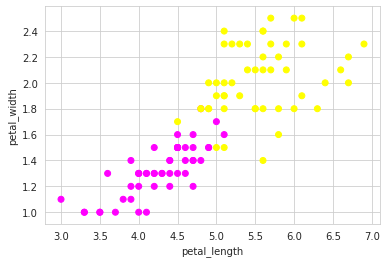

In [0]:
#Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

plt.scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

(2.7951433691756273, 7.104856630824373)

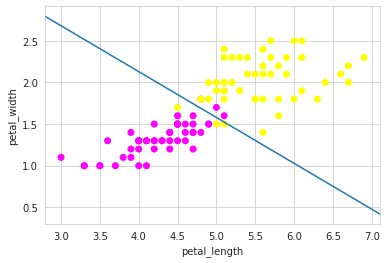

In [0]:
def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    #reshape Theta
    ThetaR = Theta.reshape(X.shape[0],1)
    N = X.shape[1]
    Y = Y.ravel()

    s = 0
    for i in range( X.shape[1]):
        xi = X[:,i:(i+1)]
        yi = Y[i]
        h = 1 / (1+np.exp(-np.dot(ThetaR.T,xi).ravel()))
        s += yi*np.log(h) + (1-yi)*np.log(1-h)

    sigma_Z = 1/(1+np.exp(-np.dot(ThetaR.T,X).ravel()))

    nll = -s
    grad = np.dot(X,(sigma_Z - Y).reshape(N,1))

    #reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)

Theta0 = np.zeros((3))

#
# Call a solver
#
ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss(Theta, IrisX, IrisY), np.array(Theta0))[0]


#
# Now plot the found separation line 
# 

plt.scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
plt.xlabel('petal_length')
plt.ylabel('petal_width')
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0]+ThetaOpt[1]*pl)/ThetaOpt[2])
plt.xlim(pl_min, pl_max)

In [0]:
a,b = logreg_loss(Theta0, IrisX, IrisY)

In [0]:
b.shape

(3,)

# Problem 5 [3p] Quantile Regression

  The least squares method results in estimates that approximate
  the conditional mean of the response variable given certain values
  of the predictor variables.  However, for many applications we are interested
  in a median or other percentile rather than the mean of the response
  variable. An approximation of a percentile can be achieved
  indirectly by using the least squares method to fit a model,
  assuming a gaussian distribution on residuals of this model and
  calculating the required percentile of the gaussian distribution.
  The problems with this commonly used technique appear when the
  distribution of residuals does not follow a gaussian distribution.

  The quantile regression
  (https://en.wikipedia.org/wiki/Quantile_regression) aims at
  directly estimating a value of the conditional percentile of the
  response variable. It is often use in e.g. sales forecasting, where
  we are interested in e.g. keeping enough items to have a 90% chance
  to cover the demand. In quantile regression, instead of minimizing the mean squared error,
  quantile regression minimizes a different cost function namely:
  \begin{equation}
  f_{\tau} = \left\{
    \begin{array}{rl}
      \tau\cdot x & \text{if } x \geq 0,\\
      -(1-\tau)\cdot x & \text{if } x < 0,
    \end{array} \right.
  \end{equation}
  where $\tau$ is the precentile of interest.


Download the house pricing data set from
    https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv. To
    load it into Python, you can use the `pandas.read_csv`
    function, similarly to how we read the height/weight table in the
    notebook for lecture 3.

    This data contains information about areas and prices of around
    5000 houses offered for sale. Imagine you want to buy a 60 squared
    meters flat. How much money do you need to have to be able to
    choose between $75\%$ of all flats offered for sale?

1. **[1.5p]** Fit a linear regression model to the dependance of a house price
    on its area using the least squares method. Fit a Gaussian
    distribution to the residuals and calculate the 75 percentile of
    this distribution (you can look it up in a percentile table, or
    use the `scipy.stats.norm.ppf` function). Check the goodness of fit
    of your model by calculating the ratio of prices below the
    estimated 75 percentile. Understand the reason of the quality of
    the model by plotting a histogram of residuals and noting that
    they do not seem to follow a Gaussian distribution.
    How many samples are within the confidence interval? Is it too large or too small?
2. **[1.5]** Fit a quantile regression model by minimizing the $f_{\tau}$
    function. To fit the model write a function returning the cost,
    and its derivative (you can assume that the derivative is 0 at the
    singular points).  Use the L-BFGS solver (without step size
    control the GD algorithm does not converge to good solutions). You
    can start the solver from the least squares solution. Check the
    goodness of fit as described above.

    Now you can calculate the 75 percentile price value for a 60
    squared meters flat using the more adequate model. 
    
    **Note**: Technically, we can not use a gradient-based
    optimization method to minimize the $f_{\tau}$ loss because it
    doesn't have a derivative at $x=0$. One solution is to use a
    subgradient method
    https://en.wikipedia.org/wiki/Subderivative. It is also
    possible to use a smooth loss function -- common variants are the
    Huber loss (https://en.wikipedia.org/wiki/Huber_loss) or a
    variant of the smooth approximation to the absolute value
    $\text{abs}(x) \approx \sqrt{x^2+\epsilon}$ with a small
    $\epsilon$. However, just ignoring the singular points tends to
    work well in practice.


In [0]:
import pandas as pd
import scipy.optimize as sopt
from scipy.stats import norm

In [0]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv',
    index_col=0)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [0]:
X = np.vstack((np.ones_like(data.rooms), data.area))
X

array([[ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ],
       [66.8 , 55.03, 70.8 , ..., 46.7 , 50.41, 48.1 ]])

In [0]:
Y = np.asarray(data.price)[None,:]
Y

array([[367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]])

[[-14.09901832]
 [  6.54132271]] (2, 1)


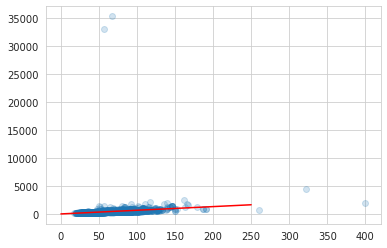

In [0]:
# Fitting linear regression model
plot_x_space = np.linspace(0,250,100)
plt.scatter(X[1,:], Y,alpha=0.2)
RY = Y.reshape(1, -1)       # Matrix 1 x N
# Theta = (X * X^T)^-1 * X * y
Theta = np.dot(np.dot(inv(np.dot(X,X.T)),X),RY.T)
Residuals = Y - np.dot(Theta.T,X)
Residuals = Residuals.ravel()
print(Theta, Theta.shape)
plt.plot(plot_x_space, compute_polynomial(plot_x_space, Theta).ravel(),color="red")
Theta0 = Theta

(0, 3000)

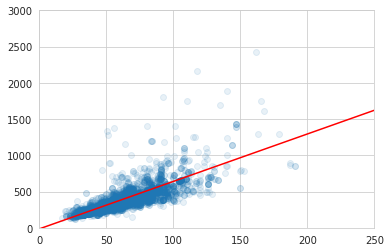

In [0]:
plt.scatter(X[1,:], Y,alpha=0.1)
plt.plot(plot_x_space, compute_polynomial(plot_x_space, Theta).ravel(),color="Red")
plt.xlim(0,250)
plt.ylim(0,3000)

In [0]:
# Fitting gaussian distribution to the residuals of linear regression
res_mean = np.mean(Residuals)
res_std = np.std(Residuals)
res_mean,res_std

(5.40780633486606e-14, 629.5549979455304)

In [0]:
# 75 percentile of distribution fited abow 
ppf_75 = sstats.norm.ppf(0.75,loc=res_mean,scale=res_std)
ppf_75

424.6283932989756

In [0]:
# numer of residuals below ppf_75 (should be equal 0.75)
np.mean(Residuals <= ppf_75)

0.9940878378378378

(array([5.918e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ -936.64488585,  2647.66468951,  6231.97426487,  9816.28384023,
        13400.5934156 , 16984.90299096, 20569.21256632, 24153.52214168,
        27737.83171705, 31322.14129241, 34906.45086777]),
 <a list of 10 Patch objects>)

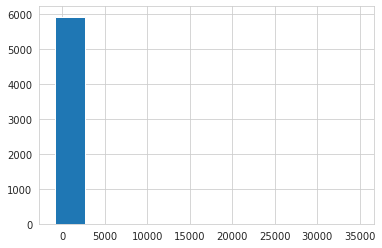

In [0]:
# Histogram of residuals
plt.hist(Residuals)

(array([1.000e+00, 1.000e+00, 3.300e+01, 3.904e+03, 1.881e+03, 6.700e+01,
        1.800e+01, 4.000e+00, 5.000e+00, 3.000e+00]),
 array([-936.64488585, -702.02080255, -467.39671925, -232.77263595,
           1.85144736,  236.47553066,  471.09961396,  705.72369727,
         940.34778057, 1174.97186387, 1409.59594718]),
 <a list of 10 Patch objects>)

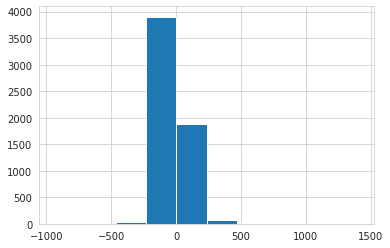

In [0]:
plt.hist(Residuals[Residuals <= 2000])

In [0]:
def cost_function(res,Theta,X,Tau):
    if res > 0:
        return Tau * res, -Tau * X
    elif res < 0:
        return (Tau-1) * res, -(Tau-1) * X
    return res, np.array([.0,.0])

In [0]:
def cost_function_for_theta(Theta,X,Y,Tau):
    ress = Y - np.dot(Theta.T,X)
    ress = ress.ravel()
    val = np.array([.0])
    der = np.array([.0,.0])
    for i,res in enumerate(ress):
        v,d = cost_function(res,Theta,X[:,i],Tau)
        val += v
        der += d
    return val/len(ress),der/len(ress)

In [0]:
def neg_errors(X,Y,Theta):
    ress = (Y - np.dot(Theta.T,X)).ravel()
    return np.mean(ress <= 0)

Quant 0.25
[20.64137477  5.02339598]
Fraction of negative errs: 0.25050675675675677
Quant 0.5
[11.67149725  5.76942524]
Fraction of negative errs: 0.5
Quant 0.75
[6.6104576  6.36053903]
Fraction of negative errs: 0.75


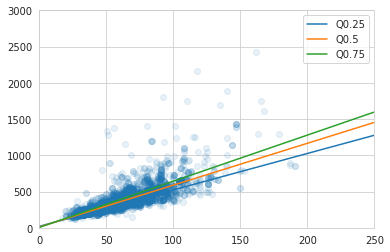

In [0]:
plot_x_space = np.linspace(0,250,100)
plt.scatter(X[1,:], Y,alpha=0.1)

for Tau in [0.25,0.5,0.75]:
    print(f"Quant {Tau}")
    Theta = sopt.fmin_l_bfgs_b(lambda Th: cost_function_for_theta(Th,X,Y,Tau), Theta0)[0]
    print(Theta)
    neg_er = neg_errors(X,Y,Theta)
    print(f"Fraction of negative errs: {neg_er}")
    plt.plot(plot_x_space, compute_polynomial(plot_x_space, Theta.reshape(2,1)).ravel(),label=f"Q{Tau}")

plt.xlim(0,250)
plt.ylim(0,3000)
plt.legend()

# Problem 6 [3p] Random Forests v2

Repeat Problem 4 from Assignment 2 using [SKlearn's Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since they don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. the AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode them using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).


**NB:** If you did Assignment 2 Problem 4, you automatically get 2 points for this problem. We highly advise to not do this problem, but do a bonus one instead.





In [0]:
german_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric',
    names=[f'A{d}' for d in range(1,25)] + ['target'], header=None, sep='\s+')
# Targets are 1&2, change to -1&+1
german_df['target'] = german_df['target'] * 2 - 3

german_train_df, german_test_df = train_test_split(german_df, test_size=0.3)
X = german_train_df[german_df.columns[:-1]]
Y = german_train_df['target']

testX = german_test_df[german_df.columns[:-1]]
testY = german_test_df['target']

In [0]:
def draw_tree(tree_,feature_names,target_names):
    dot_data = tree.export_graphviz(tree_, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render("iris") 
    dot_data = tree.export_graphviz(tree_, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph 

In [0]:
def bootstrap_idxs(df):
    N = len(df)
    idxs = np.array(df.index)
    train_idx = np.random.choice(idxs,N,replace=True)
    test_idx = np.array(list(set(idxs) - set(train_idx)))
    return train_idx,test_idx

In [0]:
class Random_forest:

    def __init__(self,X,Y,testX,testY,nattr):
        self.X = X
        self.Y = Y
        self.testX = testX
        self.testY = testY
        self.forest = []
        self.nattr = nattr
        self.oob = {}
        self.trees_errs = []
        self.tree_agreement = []
        

    def classify(self,sample):
        if not self.forest:
            raise "Forest is empty"
        classes = {}
        for tree in self.forest:
            c = tree.predict(sample)
            classes[c] = classes.get(c,0) + 1
        return max([(a,c) for c,a in classes.items()])[1]

    def add_tree(self):

        tr_idx,ts_idx = bootstrap_idxs(self.X)
        tree = DecisionTreeClassifier(random_state=0,max_features=self.nattr)
        tree.fit(self.X.loc[tr_idx],self.Y.loc[tr_idx])
        self.forest.append(tree)

        classes = tree.predict(self.testX)
        tree_err = 1 - np.mean(classes == self.testY)
        self.tree_agreement.append(classes)
        self.trees_errs.append(tree_err)

        oob_predicts = tree.predict(self.X.loc[ts_idx])
        for i,id_ in enumerate(ts_idx):
            classified_label = oob_predicts[i]
            if id_ in self.oob:
                self.oob[id_][classified_label] = self.oob[id_].get(classified_label,0) + 1
            else:
                self.oob[id_] = {classified_label: 1}
        oob_err = 1 - np.mean(oob_predicts == self.Y.loc[ts_idx])

        all_forest_preds = np.array([tree.predict(self.testX) for tree in self.forest])
        forest_preds = sstats.mode(all_forest_preds)[0].ravel()
        forest_err = 1 - np.mean(forest_preds == self.testY)
    
        print(f"Tree: {len(self.forest)}, RF err rate: {forest_err}, Tree err rate: {tree_err}, OOB err rate: {oob_err}")

    def build_forest(self,ntrees):
        print(f"Nattr: {self.nattr}")
        for i in range(ntrees):
            self.add_tree()

        forest_oob = [self.Y.loc[e] != max([(am,label) for label,am in a.items()])[1] for e,a in self.oob.items()]
        forest_oob_err = sum(forest_oob) / len(forest_oob)

        
        tree_a = np.array(self.tree_agreement)
        forest_agreement = []
        for t1 in range(ntrees):
            for t2 in range(ntrees):
                if t1 != t2:
                    forest_agreement.append(sum(tree_a[t1] == tree_a[t2])/len(tree_a[t1]))

        print(f"Forest OOB err rate: {forest_oob_err}")
        print(f"Mean tree er rate: {np.mean(self.trees_errs)}")
        print(f"Mean tree aggreement: {np.mean(forest_agreement)}")

In [0]:
RF1 = Random_forest(X,Y,testX,testY,1)
RF1.build_forest(25)

Nattr: 1
Tree: 1, RF err rate: 0.30666666666666664, Tree err rate: 0.30666666666666664, OOB err rate: 0.39922480620155043
Tree: 2, RF err rate: 0.30666666666666664, Tree err rate: 0.38, OOB err rate: 0.34090909090909094
Tree: 3, RF err rate: 0.30666666666666664, Tree err rate: 0.31000000000000005, OOB err rate: 0.34285714285714286
Tree: 4, RF err rate: 0.2833333333333333, Tree err rate: 0.37, OOB err rate: 0.3396946564885496
Tree: 5, RF err rate: 0.30666666666666664, Tree err rate: 0.35, OOB err rate: 0.34615384615384615
Tree: 6, RF err rate: 0.27, Tree err rate: 0.3633333333333333, OOB err rate: 0.344
Tree: 7, RF err rate: 0.29000000000000004, Tree err rate: 0.41000000000000003, OOB err rate: 0.405511811023622
Tree: 8, RF err rate: 0.2733333333333333, Tree err rate: 0.3533333333333334, OOB err rate: 0.33864541832669326
Tree: 9, RF err rate: 0.29666666666666663, Tree err rate: 0.3533333333333334, OOB err rate: 0.3359073359073359
Tree: 10, RF err rate: 0.27, Tree err rate: 0.41000000000

In [0]:
RF2 = Random_forest(X,Y,testX,testY,2)
RF2.build_forest(25)

Nattr: 2
Tree: 1, RF err rate: 0.33333333333333337, Tree err rate: 0.33333333333333337, OOB err rate: 0.3884615384615384
Tree: 2, RF err rate: 0.30666666666666664, Tree err rate: 0.3933333333333333, OOB err rate: 0.3203125
Tree: 3, RF err rate: 0.30333333333333334, Tree err rate: 0.31999999999999995, OOB err rate: 0.31343283582089554
Tree: 4, RF err rate: 0.28, Tree err rate: 0.31000000000000005, OOB err rate: 0.30501930501930496
Tree: 5, RF err rate: 0.29000000000000004, Tree err rate: 0.3433333333333334, OOB err rate: 0.376984126984127
Tree: 6, RF err rate: 0.2533333333333333, Tree err rate: 0.31000000000000005, OOB err rate: 0.3396946564885496
Tree: 7, RF err rate: 0.2433333333333333, Tree err rate: 0.2766666666666666, OOB err rate: 0.31135531135531136
Tree: 8, RF err rate: 0.2433333333333333, Tree err rate: 0.38, OOB err rate: 0.3426294820717132
Tree: 9, RF err rate: 0.27, Tree err rate: 0.38, OOB err rate: 0.2801556420233463
Tree: 10, RF err rate: 0.25, Tree err rate: 0.3433333333

In [0]:
RF3 = Random_forest(X,Y,testX,testY,3)
RF3.build_forest(25)

Nattr: 3
Tree: 1, RF err rate: 0.3533333333333334, Tree err rate: 0.3533333333333334, OOB err rate: 0.3665338645418327
Tree: 2, RF err rate: 0.33999999999999997, Tree err rate: 0.38, OOB err rate: 0.30204081632653057
Tree: 3, RF err rate: 0.32666666666666666, Tree err rate: 0.3433333333333334, OOB err rate: 0.34749034749034746
Tree: 4, RF err rate: 0.31000000000000005, Tree err rate: 0.3466666666666667, OOB err rate: 0.3157894736842105
Tree: 5, RF err rate: 0.29000000000000004, Tree err rate: 0.37, OOB err rate: 0.36904761904761907
Tree: 6, RF err rate: 0.29666666666666663, Tree err rate: 0.32999999999999996, OOB err rate: 0.296028880866426
Tree: 7, RF err rate: 0.2833333333333333, Tree err rate: 0.3466666666666667, OOB err rate: 0.3609958506224067
Tree: 8, RF err rate: 0.2866666666666666, Tree err rate: 0.38, OOB err rate: 0.31599999999999995
Tree: 9, RF err rate: 0.30000000000000004, Tree err rate: 0.3666666666666667, OOB err rate: 0.30681818181818177
Tree: 10, RF err rate: 0.2900000

# Problem 7 [3bp] Lasso and Adaboost

Boosting is similar to Lasso regression: it greedily selects classifiers that lead to the largest decrease in the train error. 

However, once boosting adds a tree to the ensemle, it doesn't revisit this decision. We can try to get a small improvement by trying to refit the parameters in the tree (the tree weights and distributions in leaves) using some global optimization algorithm, such as LASSO.

In this exercise:
1. Train a boosting classifier on some dataset (e.g. German Credit from Problem 6).
2. Then use the tree to build a new representation of data:
    1. Take each sample and put it through all trees.
    2. For each tree, record the leaf index.
   
   Thus, a sample is represented by the leaf ids. Encode them using 1-hot encoding and train a LASSO classifier on this new representation.


In [0]:
def entropy(counts):
    s = sum(counts)
    return -sum((counts/s)*np.log2(counts/s + 1e-100))

def gini(counts):
    s = sum(counts)
    return 1 - sum((counts/s)**2)

def mean_err_rate(counts):
    s = sum(counts)
    return 1 - np.max(counts/s)

In [0]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """
    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizluzation."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

In [0]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Stump(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        if x[self.attr] in self.subtrees:
            return self.subtrees[x[self.attr]]
        return

    def iter_subtrees(self):
        return self.subtrees.values()


    def feed_subtrees_for_rer_pruning(self,new_df):
        for val_of_attr,subtr in self.subtrees.items():
            new_df_for_subt = new_df.loc[lambda df: df[self.attr] == val_of_attr]
            subtr.feed_for_rer_pruning(new_df_for_subt)
        
    
    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f'{id(parent)}', f'{id(child)}',
                     label=f'{split_name}')

In [0]:
def get_categorical_split_and_purity(df, parent_purity, purity_fun, attr,
                                     normalize_by_split_entropy=False):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over which to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    # purity = weighted sum of children purity
    purity = 0

    for _,group_df in df.groupby(attr):
        purity += purity_fun(group_df['target'].value_counts()) * len(group_df)
    purity /= len(df)
    purity_gain = parent_purity - purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [0]:
def get_split(df, criterion='infogain', nattrs=None, depth = 0):
    # Implement termination criteria:
    # 1. Node is pure
    target_value_counts = df['target'].value_counts()
    if len(target_value_counts) == 1:
        return None
    # 2. No split is possible
    #    First get alist of attributes that can be split
    possible_splits = [e for e in df.columns if e != 'target' and len(df[e].value_counts()) != 1]
    #    Terminate early if none are possivle
    if not possible_splits:
        return None

    if nattrs:
        possible_splits = [possible_splits[i] for i in np.random.choice(len(possible_splits),nattrs)]
    
    # Get the base purity measure and the purity function
    if criterion in ['infogain', 'infogain_ratio']:
        purity_fun = entropy
    elif criterion in ['mean_err_rate']:    
        purity_fun = mean_err_rate
    elif criterion in ['gini']:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # Randomize the split by restricting the number of attributes
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner 
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity
        
        split, purity_gain = split_sel_fun(
            df, base_purity, purity_fun, attr,
            normalize_by_split_entropy=criterion.endswith('ratio'))
        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

In [0]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th
    
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Stump(df[df[self.attr] <= self.th], **subtree_kwargs),
            Stump(df[df[self.attr] > self.th], **subtree_kwargs))

    def __call__(self, x):
        if x[self.attr] <= self.th:
            return self.subtrees[0]
        else:
            return self.subtrees[1]

    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees
        
    def feed_subtrees_for_rer_pruning(self,new_df):
        new_df_left = new_df[new_df[self.attr] <= self.th]
        new_df_right = new_df[new_df[self.attr] > self.th]
        self.subtrees[0].feed_for_rer_pruning(new_df_left)
        self.subtrees[1].feed_for_rer_pruning(new_df_right)

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[0])}',
                 label=f'<= {self.th:.2f}')
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[1])}',
                 label=f'> {self.th:.2f}')

In [0]:
def get_numrical_split_and_purity(df, parent_purity, purity_fun, attr,
                                  normalize_by_split_entropy=False):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, 'target']].sort_values(attr)
    targets = attr_df['target']
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None
    best_purity_gain = -1
    N = len(attr_df)
    best_treshold = 0
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        right_counts[row_target] -= 1
        left_counts[row_target] += 1
        if attr_df.iloc[row_i][0] != attr_df.iloc[row_i+1][0]:
            purity_subtrees = ((row_i+1) * purity_fun(left_counts) + (N -1 - row_i) * purity_fun(right_counts))/N
            purity = parent_purity - purity_subtrees
            if purity > best_purity_gain:
                best_purity_gain = purity
                best_split = NumericalSplit(attr,(attr_df.iloc[row_i][0] + attr_df.iloc[row_i+1][0])/2)
                best_treshold = (attr_df.iloc[row_i][0] + attr_df.iloc[row_i+1][0])/2
    
    if normalize_by_split_entropy:
        best_purity_gain /= entropy(targets.value_counts())
    return best_split, best_purity_gain

In [0]:
class Stump:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values, 
        assert not df.isnull().values.any()
        
        # We need to let subtrees know about all targets to properly color nodes
        if 'all_targets' not in kwargs:
            kwargs['all_targets'] = sorted(df['target'].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)
        
        # Get kwargs we know about, remaning ones are for splitting
        self.all_targets = kwargs.pop('all_targets')
        kwargs.pop('depth')
        # Save debug info for visualization
        
        self.counts = df['target'].value_counts()
        self.info = {
            'num_samples': len(df),
            'entropy': entropy(self.counts),
            'gini': gini(self.counts)
        }

        if kwargs_orig['depth'] > 0:
            self.split = get_split(df, **kwargs)
        else:
            self.split = None
        if self.split:
            kwargs_orig['depth'] -= 1
            self.split.build_subtrees(df, kwargs_orig)
        
    def get_target_distribution(self, sample):
        if self.split:
            subt = self.split(sample)
            if subt:
                return subt.get_target_distribution(sample)
            else:
                return self.counts / self.info['num_samples']
        else:
            return self.counts / self.info['num_samples']
        
    def classify(self, sample):
        if self.split:
            subt = self.split(sample)
            if subt:
                return subt.classify(sample)
            else:
                l = [(v,e) for v,e in dict(self.counts).items()]
                return max(l,key = lambda x: x[1])[0]
        else:
            l = [(v,e) for v,e in dict(self.counts).items()]
            return max(l,key = lambda x: x[1])[0]

    def predict(self,test):
        preds = []
        for id_ in test.index:
            sample = test.loc[id_]
            label = sample['target']
            preds.append(self.classify(sample))
        return np.array(preds)

    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f'{c}:{freq:.2f}')
        colors = ':'.join(colors)
        labels = [' '.join(freqs_info)]
        if print_info:
            for k,v in self.info.items():
                labels.append(f'{k} = {v}')
        if self.split:
            labels.append(f'split by: {self.split.attr}')

        dot.node(f'{id(self)}',
                 label='\n'.join(labels), 
                 shape='box',
                 style='striped',
                 fillcolor=colors,
                 colorscheme='set19')
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

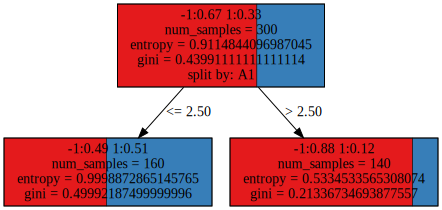

In [0]:
test = Stump(german_test_df, depth = 1)
test.draw()

In [0]:
class Adaboost():
    def __init__(self,train,n_trees):
        self.n_trees = n_trees
        self.train = train
        self.trees = []
        self.aoss = []
        self.errs = []
        self.N,_ = train.shape
        self.weights = np.ones(self.N) / self.N
        self.data = train

        for i in range(self.n_trees):
            print(f"Stump #{i+1}... ",end="")
            f = self.add_tree()
            if f == -1:
                break
            print("done")

    def add_tree(self):
        new_stump = Stump(self.data,depth=1)
        preds = new_stump.predict(self.train)
        err = np.sum((preds != self.train['target']) * self.weights)
        if err >= 0.5:
            print("No weak classifier")
            return -1
        self.trees.append(new_stump)
        self.errs.append(err)
        aos = 0.5 * np.log((1-err)/err)
        print(f"stump err: {err:.3f} aos: {aos:.3f} ", end = "")
        self.aoss.append(aos)
        self.weights *= (np.e ** ((preds * self.train['target']) * -aos))
        self.weights /= np.sum(self.weights)
        new_idx = np.random.choice(self.train.index,self.N,p = self.weights)
        self.data = self.train.loc[new_idx]
        return 0

    def classify(self,sample):
        classes = {}
        for i,t in enumerate(self.trees):
            c = t.classify(sample)
            classes[c] = classes.get(c,0) + self.aoss[i]
        return max(classes,key=classes.get)

    def predict(self,test):
        preds = []
        for id_ in test.index:
            sample = test.loc[id_]
            label = sample['target']
            preds.append(self.classify(sample))
        return np.array(preds)

    def code(self,sample):
        code = []
        for tree in self.trees:
            st = tree.split
            if sample[st.attr] <= st.th:
                code.append(1)
                code.append(0)
            else:
                code.append(0)
                code.append(1)
        return code

    def get_weights(self):
        w = []
        for i,tree in enumerate(self.trees):
            l,r = tree.split.subtrees
            dl,dr = dict(l.counts),dict(r.counts)
            cl,cr = max(dl,key = dl.get),max(dr,key = dr.get)
            w.append(cl*self.aoss[i])
            w.append(cr*self.aoss[i])
        return np.array(w)

In [0]:
AB = Adaboost(german_train_df,25)

Stump #1... stump err: 0.289 aos: 0.451 done
Stump #2... stump err: 0.338 aos: 0.337 done
Stump #3... stump err: 0.396 aos: 0.211 done
Stump #4... stump err: 0.441 aos: 0.119 done
Stump #5... stump err: 0.412 aos: 0.177 done
Stump #6... stump err: 0.454 aos: 0.092 done
Stump #7... stump err: 0.455 aos: 0.091 done
Stump #8... stump err: 0.440 aos: 0.121 done
Stump #9... stump err: 0.482 aos: 0.037 done
Stump #10... stump err: 0.452 aos: 0.096 done
Stump #11... stump err: 0.448 aos: 0.104 done
Stump #12... stump err: 0.436 aos: 0.128 done
Stump #13... stump err: 0.463 aos: 0.075 done
Stump #14... stump err: 0.442 aos: 0.117 done
Stump #15... stump err: 0.427 aos: 0.148 done
Stump #16... stump err: 0.454 aos: 0.091 done
Stump #17... stump err: 0.459 aos: 0.082 done
Stump #18... stump err: 0.425 aos: 0.152 done
Stump #19... stump err: 0.471 aos: 0.057 done
Stump #20... stump err: 0.475 aos: 0.049 done
Stump #21... stump err: 0.480 aos: 0.040 done
Stump #22... stump err: 0.463 aos: 0.074 do

In [0]:
print("Acc on test data: ", end = "")
print(np.mean(AB.predict(german_test_df) == np.array(german_test_df['target'])))

print("Acc on train data: ", end = "")
print(np.mean(AB.predict(german_train_df) == np.array(german_train_df['target'])))

print("Confusion matrix on test data: ")
print(confusion_matrix(np.array(german_test_df['target']), AB.predict(german_test_df)))

print("Confusion matrix on train data: ")
print(confusion_matrix(np.array(german_train_df['target']), AB.predict(german_train_df)))

Acc on test data: 0.7033333333333334
Acc on train data: 0.7757142857142857
Confusion matrix on test data: 
[[187  15]
 [ 74  24]]
Confusion matrix on train data: 
[[470  28]
 [129  73]]


Code is 1-0 vector, if in i-th tree sample end in left subtree, then v[2*i] = 0 and v[2*i + 1] = 1
Weights is vector describing three leafs class distribution multiplied by trees aoss (amount of say - weight)

We can notice that sign(sum(code * weights)) is equal to class prediction

In [0]:
sample = german_train_df.loc[german_train_df.index[0]]

In [0]:
print(AB.code(sample))

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]


In [0]:
AB.get_weights()

array([-0.45116619, -0.45116619,  0.33660856, -0.33660856, -0.21102787,
        0.21102787,  0.11872238, -0.11872238,  0.17720775, -0.17720775,
       -0.09186371,  0.09186371,  0.0910761 , -0.0910761 , -0.12141   ,
       -0.12141   , -0.03654709,  0.03654709,  0.09570799, -0.09570799,
       -0.10358602,  0.10358602, -0.12843398,  0.12843398,  0.07477227,
       -0.07477227,  0.11718849, -0.11718849, -0.14795854,  0.14795854,
        0.09149223, -0.09149223, -0.08194292,  0.08194292,  0.15163376,
       -0.15163376, -0.05727533,  0.05727533, -0.04939176,  0.04939176,
       -0.04022884, -0.04022884,  0.07444489, -0.07444489, -0.10322606,
        0.10322606,  0.12571024, -0.12571024,  0.07966265, -0.07966265])

In [0]:
def predict_with_code(test_df):
    preds = []
    w = AB.get_weights()
    for i in test_df.index:
        sample = test_df.loc[i]
        c = AB.code(sample)
        preds.append(int(np.sign(np.sum(c*w))))
    return np.array(preds)

In [0]:
np.mean(predict_with_code(german_test_df) == np.array(german_test_df['target']))

0.7033333333333334

In [0]:
np.mean(AB.predict(german_test_df) == predict_with_code(german_test_df))

1.0

Now we can code data like abow

In [0]:
def code_with_weights(df):
    data = []
    w = AB.get_weights()
    for i in df.index:
        sample = df.loc[i]
        c = AB.code(sample)
        data.append(list(c*w))
    return np.array(data)

In [0]:
coded_train = code_with_weights(german_train_df)

In [0]:
coded_test = code_with_weights(german_test_df)

In [0]:
train_target = np.array(german_train_df['target'])
test_target = np.array(german_test_df['target'])

In [0]:
alpha = 0.001
Lasso_ = Lasso(alpha=alpha)
Lasso_.fit(coded_train,train_target)
preds_test = Lasso_.predict(coded_test)
preds_test = (preds_test >= 0) * 2 - 1
preds_train = Lasso_.predict(coded_train)
preds_train = (preds_train >= 0) * 2 - 1

In [0]:
print(f"Coded with weights, Lasso regresion, alpha = {alpha}")
print("Acc on test data: ", end = "")
print(np.mean(preds_test == np.array(german_test_df['target'])))

print("Acc on train data: ", end = "")
print(np.mean(preds_train == np.array(german_train_df['target'])))

print("Confusion matrix on test data: ")
print(confusion_matrix(np.array(german_test_df['target']), preds_test))

print("Confusion matrix on train data: ")
print(confusion_matrix(np.array(german_train_df['target']), preds_train))

Coded with weights, Lasso regresion, alpha = 0.001
Acc on test data: 0.7066666666666667
Acc on train data: 0.78
Confusion matrix on test data: 
[[186  16]
 [ 72  26]]
Confusion matrix on train data: 
[[474  24]
 [130  72]]


In [0]:
C = 10
LogisticR = LogisticRegression(C=C)
LogisticR.fit(coded_train,train_target)
preds_test_logistic = LogisticR.predict(coded_test)
preds_test_logistic = (preds_test_logistic >= 0) * 2 - 1
preds_train_logistic = LogisticR.predict(coded_train)
preds_train_logistic = (preds_train_logistic >= 0) * 2 - 1

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(f"Coded with weights, Logistic regression, C = {10}")
print("Acc on test data: ", end = "")
print(np.mean(preds_test_logistic == np.array(german_test_df['target'])))

print("Acc on train data: ", end = "")
print(np.mean(preds_train_logistic == np.array(german_train_df['target'])))

print("Confusion matrix on test data: ")
print(confusion_matrix(np.array(german_test_df['target']), preds_test_logistic))

print("Confusion matrix on train data: ")
print(confusion_matrix(np.array(german_train_df['target']), preds_train_logistic))

Coded with weights, Logistic regression, C = 10
Acc on test data: 0.7
Acc on train data: 0.78
Confusion matrix on test data: 
[[182  20]
 [ 70  28]]
Confusion matrix on train data: 
[[458  40]
 [114  88]]


We can try use only coding, without weights.

In [0]:
def code_without_weights(df):
    data = []
    for i in df.index:
        sample = df.loc[i]
        c = AB.code(sample)
        data.append(c)
    return np.array(data)

In [0]:
coded_train = code_without_weights(german_train_df)
coded_test = code_without_weights(german_test_df)

In [0]:
alpha = 0.001
Lasso_ = Lasso(alpha=alpha)
Lasso_.fit(coded_train,train_target)
preds_test = Lasso_.predict(coded_test)
preds_test = (preds_test >= 0) * 2 - 1
preds_train = Lasso_.predict(coded_train)
preds_train = (preds_train >= 0) * 2 - 1

In [0]:
print(f"Coded without weights, Lasso regresion, alpha = {alpha}")
print("Acc on test data: ", end = "")
print(np.mean(preds_test == np.array(german_test_df['target'])))

print("Acc on train data: ", end = "")
print(np.mean(preds_train == np.array(german_train_df['target'])))

print("Confusion matrix on test data: ")
print(confusion_matrix(np.array(german_test_df['target']), preds_test))

print("Confusion matrix on train data: ")
print(confusion_matrix(np.array(german_train_df['target']), preds_train))

Coded without weights, Lasso regresion, alpha = 0.001
Acc on test data: 0.7
Acc on train data: 0.7814285714285715
Confusion matrix on test data: 
[[181  21]
 [ 69  29]]
Confusion matrix on train data: 
[[465  33]
 [120  82]]


In [0]:
C = 25
LogisticR = LogisticRegression(C=C)
LogisticR.fit(coded_train,train_target)
preds_test_logistic = LogisticR.predict(coded_test)
preds_test_logistic = (preds_test_logistic >= 0) * 2 - 1
preds_train_logistic = LogisticR.predict(coded_train)
preds_train_logistic = (preds_train_logistic >= 0) * 2 - 1

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(f"Coded without weights, Logistic regression, C = {C}")
print("Acc on test data: ", end = "")
print(np.mean(preds_test_logistic == np.array(german_test_df['target'])))

print("Acc on train data: ", end = "")
print(np.mean(preds_train_logistic == np.array(german_train_df['target'])))

print("Confusion matrix on test data: ")
print(confusion_matrix(np.array(german_test_df['target']), preds_test_logistic))

print("Confusion matrix on train data: ")
print(confusion_matrix(np.array(german_train_df['target']), preds_train_logistic))

Coded without weights, Logistic regression, C = 25
Acc on test data: 0.7033333333333334
Acc on train data: 0.7742857142857142
Confusion matrix on test data: 
[[177  25]
 [ 64  34]]
Confusion matrix on train data: 
[[448  50]
 [108  94]]
